## Installing/loading the required libraries
Set the variable `INSTALL` to `TRUE` to install the libraries, set to `FALSE` once this has been done.

In [13]:
required_libs = c("dplyr", "readr", "sqldf", "igraph", "ggraph", "raster")
for (l in required_libs) {
    if (!require(l, character.only = TRUE)) {
        install.packages(l)
        library(l, character.only = TRUE)
    }
}

Loading required package: raster

Loading required package: sp


Attaching package: ‘sp’


The following object is masked from ‘package:ggraph’:

    geometry



Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select




# Load the data
We load two data files: `air_travel_MB.csv` contains the network description and `airport_codes_CAN.csv`, which has some information about all airfields in Canada.

The data in air_travel_MB is pre-processed. It represents an extreme simplification of a much more complete dataset (Rows: 2,757,430; Columns: 19) giving, for a given time period, the total number of travellers between 3734 airports worldwide along trips including up to 5 intermediate stops. 

What I did is to keep only the airports in Manitoba. Any airport outside of Manitoba is set as `RoW` (rest of the world). Also, the existing multi-leg trips within Manitoba are "decomposed": if the data had 10 people flying, say, YWG$\to$YQD$\to$YTH (Winnipeg to The Pas to Thompson), these would appear as 10 people flying from YWG to YQD and 10 people flying from YQD to YTH. 

Flights to and from RoW are decomposed the same way as flights within Manitoba, increasing the number of trips between RoW and YWG. Indeed, 5 passengers flying RoW$\to$YWG$\to$YQD and 5 passengers flying RoW$\to$YWG$\to$YBR (Brandon) will show as 10 passengers flying RoW to YWG, together with 5 passengers flying YWG$\to$YQD and 5 passengers flying YWG$\to$YBR.

In [4]:
air_travel_MB <- read_delim("air_travel_MB.csv", 
                     delim = ",", escape_double = FALSE,
                               trim_ws = TRUE)
airport_codes_MB <- read_csv("airport_codes_CAN.csv") %>%
  filter(ISO_Region == "CA-MB")
head(air_travel_MB)
(airport_codes_MB)

Rows: 108 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): orig, dest
dbl (1): vol

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2792 Columns: 18
── Column specification ────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Identifier, Type, Name, ISO_Country_Code, ISO_Region, Municipality...
dbl  (4): Airport_ID, Latitude, Longitude, Elevation_Ft
lgl  (2): Continent, Is_Scheduled_Service

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


orig,dest,vol
<chr>,<chr>,<dbl>
RoW,YBR,2002
RoW,YTH,18
RoW,YWG,157323
RoW,YYQ,1474
XLB,RoW,766
XLB,XTL,114


Airport_ID,Identifier,Type,Name,Latitude,Longitude,Elevation_Ft,Continent,ISO_Country_Code,ISO_Region,Municipality,Is_Scheduled_Service,GPS_Code,IATA_Code,Local_Code,Home_Link,Wikipedia_Link,Keywords
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
35391,CA-0006,closed,RCAF Station Carberry,49.87210,-99.39730,NA,NA,CA,CA-MB,Carberry,FALSE,NA,NA,NA,NA,https://en.wikipedia.org/wiki/RCAF_Station_Carberry,NA
39668,CA-0022,closed,Anama Bay-Dauphin River Airport,51.96267,-98.13684,NA,NA,CA,CA-MB,NA,FALSE,NA,NA,NA,NA,NA,NA
39677,CA-0031,closed,Austin Airport,49.93333,-98.91666,NA,NA,CA,CA-MB,NA,FALSE,NA,NA,NA,NA,NA,NA
39686,CA-0040,closed,Beausejour Airport,50.13697,-96.20822,NA,NA,CA,CA-MB,Beausejour,FALSE,NA,NA,NA,NA,NA,NA
39694,CA-0048,closed,Bethany Airport,50.35000,-99.75000,NA,NA,CA,CA-MB,NA,FALSE,NA,NA,NA,NA,NA,NA
39696,CA-0050,closed,Bird Airport,56.50000,-94.21667,NA,NA,CA,CA-MB,NA,FALSE,NA,NA,NA,NA,NA,NA
39698,CA-0052,closed,Wallace Lake Airport,51.00835,-95.42192,NA,NA,CA,CA-MB,Bissett,FALSE,NA,NA,NA,NA,NA,NA
39728,CA-0082,closed,Carberry Airport,49.85000,-99.31667,NA,NA,CA,CA-MB,NA,FALSE,NA,NA,NA,NA,NA,NA
39745,CA-0099,closed,Cormorant Lake Airport,54.23333,-100.60000,NA,NA,CA,CA-MB,NA,FALSE,NA,NA,NA,NA,NA,NA


# Data wrangling remark
Note that there is an alternative to `dplyr` (the package that allows us to use the pipe `%>%`); it is indeed possible to treat data frames as SQL tables and run SQL queries on them. This may make more sense to some of you. For illustration, to create the table of movements, I used the following command (which can run, since it is not destructive of what we have already done).

In [5]:
query = 
"SELECT orig,dest,SUM(vol) AS vol
FROM air_travel_MB
GROUP BY orig,dest
ORDER BY orig,dest"

air_travel_MB = sqldf::sqldf(query)

Finish preparing the data: we want to record the latitude and longitudes for all the airports in the `air_travel_MB` data set. Note that we give `RoW` a location: we will show it as an additional vertex in the graph. (I picked somewhere close to but not in Manitoba.)

In [6]:
IATA_codes_MB_in_data = data.frame(IATA = sort(unique(union(air_travel_MB$orig,
                                                            air_travel_MB$dest))))
lon = c()
lat = c()
for (i in 1:dim(IATA_codes_MB_in_data)[1]) {
  idx = which(airport_codes_MB$IATA_Code == IATA_codes_MB_in_data$IATA[i])
  if (length(idx) == 0) {
    lon = c(lon, -90)
    lat = c(lat, 49.5)
  } else {
    lon = c(lon, airport_codes_MB$Longitude[idx])
    lat = c(lat, airport_codes_MB$Latitude[idx])
  }
}
IATA_codes_MB_in_data$lon = lon
IATA_codes_MB_in_data$lat = lat

head(IATA_codes_MB_in_data)

,IATA,lon,lat
,<chr>,<dbl>,<dbl>
1,RoW,-90.0000,49.5000
2,XLB,-101.4690,58.6175
3,XSI,-98.9072,56.7928
4,XTL,-98.5122,58.7061
5,YBR,-99.9519,49.9100
6,YBT,-101.6790,57.8894


We are now in a position to make the graph and plot it in simple form. We add the volume as the weight of the arcs.

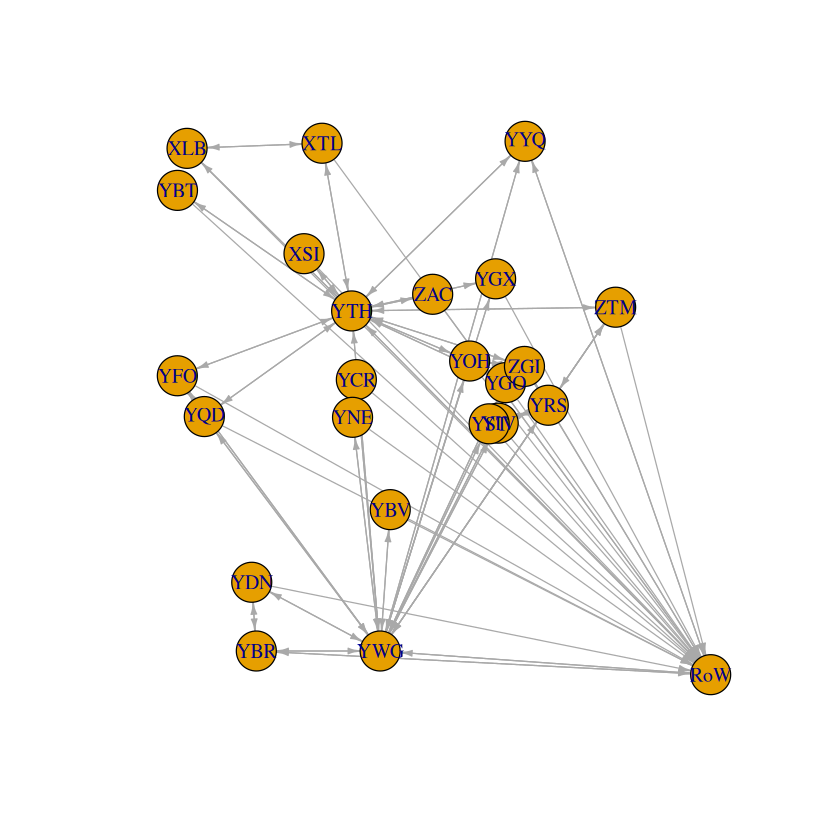

In [7]:
G = graph_from_data_frame(air_travel_MB)
V(G)$x = lon
V(G)$y = lat

plot(G, edge.arrow.size = 0.5, edge.arrow.width = 0.75)

We also make a subgraph without `RoW` to focus on the properties really specific to Manitoba.

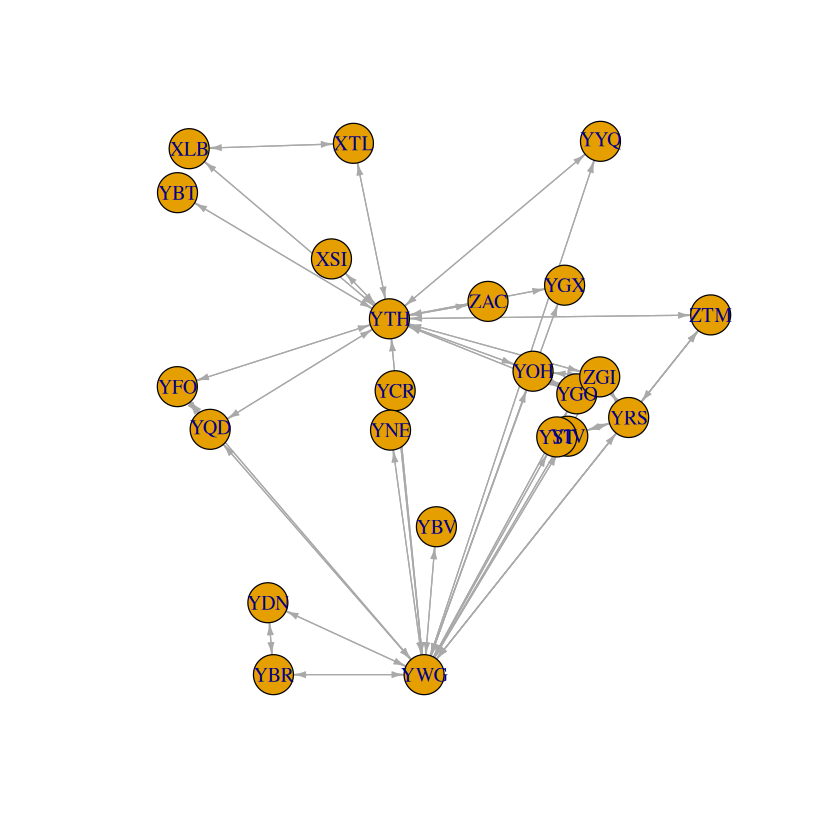

In [8]:
G_MB = induced_subgraph(G, V(G)$name[V(G)$name != "RoW"])
plot(G_MB, edge.arrow.size = 0.5, edge.arrow.width = 0.75)

# Making nicer plots
Before we explore the properties of the graph, let us spend a little time on visualisation. This is not to be neglected: nice plots help more than you think.

The next piece of code does the following:
- Redefine the output size (does it once for all, need to modify if need be)
- Uses the library `raster` to read in the shape file for Canada
- Selects Manitoba from the Canada shape file
- Plots Manitoba
- Plots the graph

In [14]:
options(repr.plot.width=15, repr.plot.height=15)
Canada <- getData('GADM', country='CAN', level=1)
MB <- Canada[Canada$NAME_1 == "Manitoba",]
plot(MB)
plot(G, add = TRUE, rescale = FALSE,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

ERROR: Error in getData("GADM", country = "CAN", level = 1): getData has been removed. Please use the geodata package instead.


Let us add the degree information as the size of the vertices.

In [12]:
plot(MB)
V(G)$size = degree(G, mode = "out")*10
plot(G, add = TRUE, rescale = FALSE,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

ERROR: Error: object 'MB' not found


In [ ]:
plot(MB)
V(G_MB)$size = degree(G_MB)*5
plot(G_MB, add = TRUE, rescale = FALSE,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

Now let us take a look at the arcs. Maybe change their thickness to reflect the volumes along the arcs?

In [ ]:
plot(MB)
V(G_MB)$size = degree(G_MB)*5
plot(G_MB, add = TRUE, rescale = FALSE, edge.width = E(G_MB)$vol,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

My guess: some of the arcs are so massive that this is all we can see. So let us renormalise the values of the weights. First, what do they look like now?

In [ ]:
sort(E(G)$vol)

So, yes, clearly a bit too much variation. If we scale linearly by multiplying by a constant, we will most likely lose the information on the small weights. Just to check that we are intuiting correctly, though, let us try once doing this.

In [ ]:
plot(MB)
V(G)$size = degree(G)*5
plot(G, add = TRUE, rescale = FALSE, edge.width = E(G)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

In [ ]:
plot(MB)
V(G)$size = degree(G)*5
plot(G, add = TRUE, rescale = FALSE, edge.width = E(G)$vol*0.0005,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

What we suspected, indeed: to make the arcs with the largest volume not too large, we had to essentially get rid of the weight of the arcs with small volumes. So what we want to do is to process the values through a function that would make the smaller values larger relative to the larger ones or the larger values closer to the smaller one, then scale the result. For this, it is good to look at what the values look like.

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
plot(sort(E(G)$vol), type = "b")

One way around this could be to use a so-called sigmoid function. This is a function of the following form:
$$
f(x) = \dfrac{1}{1+e^{-cx}},
$$
where $\mathbb{R}\ni c>0$ is a parameter.
This function has the following properties: $\lim_{x\to-\infty}f(x)=0$ and $\lim_{x\to\infty}f(x)=1$. By playing with the value of $c$, one can set the beahviour of $f$. Let us see how different values of $c$ influence the value of the points. (The `viridis` palette used starts with yellow and goes towards green and then purple.)

In [ ]:
sigmoid = function(x, c) {
    return(1/(1+exp(-c*x)))
}

values_c = c(0.0001, 0.0005, 0.001, 0.005, 0.01)
x = 1:length(E(G))
values_x = sort(E(G)$vol)
my_palette = viridis::viridis(length(values_c))

# First, we plot the "data" (scaled to the [0,1] range)
plot(x, (values_x-min(values_x))/max(values_x), 
     type = "b", col = "red",
     ylim = (range(values_x)-min(values_x))/max(values_x))
for (c in values_c) {
    idx = which(c == values_c) # Find which position in the values_c vector, for colour
    tmp = sigmoid(values_x, c) # Let us rescale the result to between 0 and 1
    tmp = tmp-min(tmp)
    tmp = tmp/max(tmp)
    lines(x, tmp, type = "b", col = my_palette[idx])
}

That last one looks quite nice. We most likely will have to multiply by a factor, so we compute the values in advance.

In [ ]:
options(repr.plot.width=15, repr.plot.height=15)
edge_widths = 2*sigmoid(E(G)$vol, 0.1)

plot(MB)
V(G)$size = degree(G)*5
plot(G, add = TRUE, rescale = FALSE, 
     edge.width = edge_widths, type = "b",
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

Well, after all this, I am not convinced we achieved between than we had done above but just a linear scaling. So when we want a a good plot, we'll come back to that solution.

In [ ]:
plot(MB)
V(G)$size = degree(G)*5
plot(G, add = TRUE, rescale = FALSE, edge.width = E(G)$vol*0.0005,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

In [ ]:
plot(MB)
V(G_MB)$size = degree(G_MB)*5
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

## Eccentricities and related measures

In [ ]:
distances(G_MB)

In [ ]:
distances(G_MB, mode = "out")

In [ ]:
eccentricity(G_MB)
eccentricity(G_MB, mode = "in")
eccentricity(G_MB, mode = "out")
writeLines("Radius (all/in/out):")
radius(G_MB)
radius(G_MB, mode = "in")
radius(G_MB, mode = "out")
writeLines("Diameter (all/in/out:")
diameter(G_MB)
max(distances(G_MB, mode = "in"))
max(distances(G_MB, mode = "out"))

## Central points, centre, periphery
For simplicity, I only show the out-degree case. And just to show how easily it's done: let's colour the vertices in the centre red and those in the periphery blue.

In [ ]:
e_out = eccentricity(G_MB, mode = "out")
writeLines("Central points:")
V(G_MB)[which(e_out == min(e_out))]$name
V(G_MB)[which(e_out == min(e_out))]$color = "red"
writeLines("Periphery:")
V(G_MB)[which(e_out == max(e_out))]$name
V(G_MB)[which(e_out == max(e_out))]$color = "blue"

plot(MB)
V(G_MB)$size = degree(G_MB)*5
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

## Girth
Recall that `girth` in `igraph` assumes the graph is undirected.

In [ ]:
girth(G)
girth(G_MB)

## Density
What fraction of possible arcs/edges are present?

In [ ]:
edge_density(G)
edge_density(G_MB)

# Connectedness and related
## Connectedness

In [ ]:
is.connected(G_MB, "weak")
is.connected(G_MB, "strong")

So there is a single strongly connected component.
## Articulation points
The function assumes the graph is undirected, even in the directed case.

In [ ]:
articulation_points(G_MB)

So removing Winnipeg or Thompson disconnects the graph.

In [ ]:
G_disconnected = induced_subgraph(G_MB, V(G_MB)$name[V(G_MB)$name != "YTH"])
is_connected(G_disconnected)

comps <- components(G_disconnected)$membership
colbar <- rainbow(max(comps)+1)
V(G_disconnected)$color <- colbar[comps+1]

plot(MB)
V(G_disconnected)$size = rep(50,length(V(G_disconnected)))
plot(G_disconnected, add = TRUE, rescale = FALSE, 
     edge.width = E(G_disconnected)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

# Cliques

In [ ]:
lc = largest_cliques(G_MB)
lc
vert_largest_clique = lc[[1]]

V(G_MB)$color = "blue"
V(G_MB)[vert_largest_clique]$color = "red"

plot(MB)
V(G_MB)$size = rep(50,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_disconnected)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

# Centrality
## Degree-centrality

In [ ]:
degree(G_MB, mode = "out")
degree(G_MB, mode = "in")
degree(G_MB)
distrib_outdegree = degree_distribution(G, mode = "out")
distrib_indegree = degree_distribution(G, mode = "in")
distrib_degree = degree_distribution(G)

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

distrib_outdegree = degree_distribution(G_MB, mode = "out")
distrib_indegree = degree_distribution(G_MB, mode = "in")
distrib_degree = degree_distribution(G_MB)

y_max = max(max(distrib_indegree, distrib_outdegree), distrib_degree)
plot(distrib_degree, type = "b", lwd = 2, col = "black", ylim = c(0, y_max))
points(distrib_outdegree, type = "b", lwd = 2, col = "blue")
points(distrib_indegree, type = "b", lwd = 2, col = "red")

# K-nearest neighbours
For info, the return values of the function `knn` are
- `knn`: A numeric vector giving the average nearest neighbor degree for all vertices in vids.
- `knnk`: A numeric vector, its length is the maximum (total) vertex degree in the graph. The first element is the average nearest neighbor degree of vertices with degree one, etc.

In [ ]:
knn(G_MB, mode = "all")
knn(G_MB, mode = "in")
knn(G_MB, mode = "out")

Let us plot the values in the graph, say, for the in-knn.

In [ ]:
options(repr.plot.width=15, repr.plot.height=15)

knn_in = knn(G_MB, mode = "in")$knn
knn_in_bar = sort(unique(round(knn_in)))
colbar <- viridis::viridis(max(ceiling(knn_in)))
V(G_MB)$color <- colbar[round(knn_in)]

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)
DescTools::ColorLegend(x = "right", col = colbar, 
                       width = 0.5, inset = 0.1,
                       labels = sprintf("%d", knn_in_bar))

# Coreness

In [ ]:
coreness(G_MB, "all")
coreness(G_MB, "in")
coreness(G_MB, "out")

Let us look at the out-coreness, for instance, and colour the vertices as a function of that.

In [ ]:
cores = coreness(G_MB, "out")
colbar <- viridis::viridis(max(cores))
V(G_MB)$color <- colbar[cores]

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)
legend("bottomright", 
       legend = sprintf("%d", sort(unique(cores))),
       pch = rep(19, length(unique(cores))),
       pt.cex = rep(5, length(unique(cores))),
       cex = 2,
       box.lty=0,
       col = colbar[sort(unique(cores))])

# Betweenness

In [ ]:
betweenness(G)
betweenness(G_MB)

In [ ]:
betweenness_MB = betweenness(G_MB)
# shift numbers by 1 because the second command fails when there are zeros..
colbar <- viridis::viridis(max(ceiling(betweenness_MB))+1)
V(G_MB)$color <- colbar[round(betweenness_MB)+1]
# For the label of the colour bar
colbar_str = sprintf("%d", range(unique(round(betweenness_MB))))

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)
DescTools::ColorLegend(x = "right", col = colbar, 
                       width = 0.5, inset = 0.1,
                       labels = colbar_str)

# Closeness
First, the unweighted case, i.e., using the geodesic distance.

In [ ]:
round(closeness(G_MB, mode = "all"),5)
round(closeness(G_MB, mode = "in"),5)
round(closeness(G_MB, mode = "out"),5)

We can also compute closeness using weighted arcs, i.e., using the travel volumes. Geodesic distance shown for comparison. We save the results for future manipulation.

In [ ]:
# Unweighted case
cl_MB_U = closeness(G_MB, mode = "out")
cl_MB_U
# Weighted case
cl_MB_W = closeness(G_MB, mode = "out", weights = E(G_MB)$vol)
cl_MB_W

To prepare for plots, let us look at the ranges of values.

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

range(cl_MB_U)
plot(sort(cl_MB_U))
range(cl_MB_W)
plot(sort(cl_MB_W))

So if we multiply the first values by 10,000 and the second ones by 1e7, we should get good ranges of variation.

In [ ]:
range(cl_MB_U * 1e4)
range(cl_MB_W * 1e7)

Indeed, so that's what we do.

In [ ]:
options(repr.plot.width=15, repr.plot.height=15)

cl_MB_U_tmp = cl_MB_U * 1e4
Delta_cl = ceiling(max(cl_MB_U_tmp)-min(cl_MB_U_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_U_tmp-min(cl_MB_U_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_U_tmp))

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)
DescTools::ColorLegend(x = "right", col = colbar, 
                       width = 0.5, inset = 0.1,
                       labels = colbar_str)

In [ ]:
cl_MB_W_tmp = cl_MB_W * 1e7
Delta_cl = ceiling(max(cl_MB_W_tmp)-min(cl_MB_W_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_W_tmp-min(cl_MB_W_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_W_tmp))

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)
DescTools::ColorLegend(x = "right", col = colbar, 
                       width = 0.5, inset = 0.1,
                       labels = colbar_str)

One interesting remark here: closeness radically changes when considering the unweighted and weighted version. Just to confirm this, let us plot the two graphs side by side.

In [ ]:
par(mfrow=c(1,2))

# Unweighted MB only
Delta_cl = ceiling(max(cl_MB_U_tmp)-min(cl_MB_U_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_U_tmp-min(cl_MB_U_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_U_tmp))
plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

# Weighted MB only
Delta_cl = ceiling(max(cl_MB_W_tmp)-min(cl_MB_W_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_W_tmp-min(cl_MB_W_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_W_tmp))
plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

So Thompson (YTH) is has higher closeness centrality than Winnipeg (YWG) when passenger volumes are considered. Does the situation change if we recall that Winnipeg is quite connected to the rest of the world? We prepare the computations and the plots as we had done earlier.

In [ ]:
# Unweighted case
cl_MB_RoW_U = closeness(G, mode = "out")
range(cl_MB_RoW_U)
# Weighted case
cl_MB_RoW_W = closeness(G, mode = "out", weights = E(G)$vol)
range(cl_MB_RoW_W)

Ranges are quite similar to those earlier, so we can probably just do the same as before. We will plot the 4 figures this time. First row is as before, second row is with rest of the world information thrown in.

In [ ]:
par(mfrow=c(2,2))

cl_MB_RoW_U_tmp = cl_MB_RoW_U * 1e4
cl_MB_RoW_W_tmp = cl_MB_RoW_W * 1e7

# Unweighted MB only
Delta_cl = ceiling(max(cl_MB_U_tmp)-min(cl_MB_U_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_U_tmp-min(cl_MB_U_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_U_tmp))
plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

# Weighted MB only
Delta_cl = ceiling(max(cl_MB_W_tmp)-min(cl_MB_W_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_W_tmp-min(cl_MB_W_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_W_tmp))
plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

# Unweighted MB with RoW
Delta_cl = ceiling(max(cl_MB_RoW_U_tmp)-min(cl_MB_RoW_U_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G)$color <- colbar[round(cl_MB_RoW_U_tmp-min(cl_MB_RoW_U_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_RoW_U_tmp))
plot(MB)
V(G)$size = rep(75,length(V(G)))
plot(G, add = TRUE, rescale = FALSE, 
     edge.width = E(G)$vol*0.0001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

# Weighted MB with RoW
Delta_cl = ceiling(max(cl_MB_RoW_W_tmp)-min(cl_MB_RoW_W_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G)$color <- colbar[round(cl_MB_RoW_W_tmp-min(cl_MB_RoW_W_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_RoW_W_tmp))
plot(MB)
V(G)$size = rep(75,length(V(G)))
plot(G, add = TRUE, rescale = FALSE, 
     edge.width = E(G)$vol*0.0001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

Actually, things do not change, except that RoW becomes important as well.